In [1]:
# https://www.kaggle.com/code/abhikuks/function-transformer-in-depth-understanding

FunctionTransformer is used to apply mathematical transformations to features in order to:

    Make data approximately normally distributed
    Reduce skewness
    Improve model performance (especially linear models)

To know if a data is normally distributed:

    sns.kdeplot
    sns.distplot
    pd.skew() -> skewness
    pd.kurt -> kurtosis
    QQ plot

Function transformers has different types to make data normally distributed:

    1. Log Transformer 
    * Mostly used on right skewd data
    * It cannot be appplied to negative numbers as we cannot calculate the log of negative numbers.
    * Cannot handle zeros values as log 0 is undefined in real number system
        
    2. Reciprocal
    * It is used when we want to change the small values to big values and vice-versa
        
    3. Square
    * Mostly used on left skewed data
    
    4. SquareRoot
    
    5. Custom Transformer
    * We can make our own transformations

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

C:\Users\ashis\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
df= pd.read_csv('train.csv',usecols=['Age','Fare','Survived'])
print(df.shape)
df.sample(2)

(891, 3)


,Survived,Age,Fare
477,0,29.0,7.0458
238,0,19.0,10.5000


In [4]:
df.isnull().sum()

Survived      0
Age         177
Fare          0
dtype: int64

In [5]:
df.fillna(df['Age'].mean(),inplace=True)

In [6]:
df.isnull().sum()

Survived    0
Age         0
Fare        0
dtype: int64

In [15]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('Survived',axis=1),
                                                    df['Survived'],
                                                    test_size=0.2,
                                                    random_state=24)
print(x_train.shape,x_test.shape)

(712, 2) (179, 2)


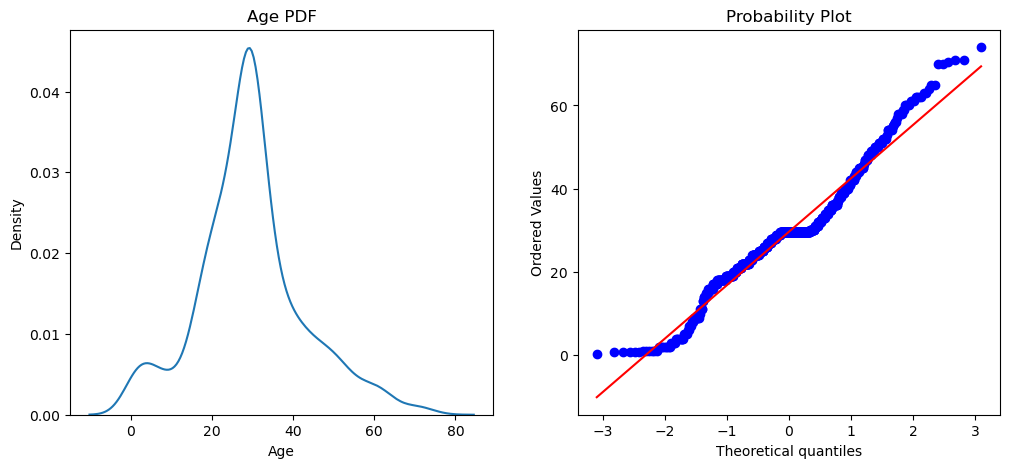

In [16]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize =(12,5))

ax1.set_title('Age PDF')
sns.kdeplot(x_train['Age'],ax=ax1)

ax2.set_title('Age QQ Plot')
stats.probplot(x_train['Age'],dist='norm',plot = plt)

plt.show()

It's not exactly normal dat but it is kind of normal as most of the time in QQ Plot the data is aligned to the linear line.

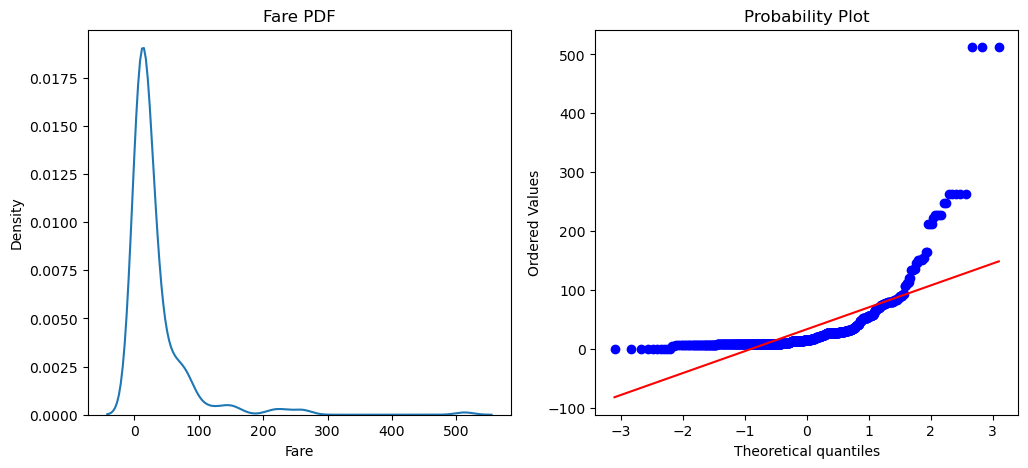

In [17]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12,5))

ax1.set_title('Fare PDF')
sns.kdeplot(x_train['Fare'],ax=ax1)

ax2.set_title('Fare QQ Plot')
stats.probplot(x_train['Fare'],dist='norm',plot=plt)

plt.show()

It is rightly skewed. So we will use log transformation.

In [18]:
clf = LogisticRegression()
clf2 = DecisionTreeClassifier()

In [19]:
clf.fit(x_train,y_train)
clf2.fit(x_train,y_train)
    
y_pred = clf.predict(x_test)
y_pred1 = clf2.predict(x_test)
    
print("Accuracy LR",accuracy_score(y_test,y_pred))
print("Accuracy DT",accuracy_score(y_test,y_pred1))

Accuracy LR 0.7206703910614525
Accuracy DT 0.6871508379888268


In [20]:
trf1 = FunctionTransformer(func = np.log1p)

x_train_transformed = trf1.fit_transform(x_train)
x_test_transformed = trf1.transform(x_test)

clf.fit(x_train_transformed,y_train)
clf2.fit(x_train_transformed,y_train)

clf.predict(x_test_transformed)
clf2.predict(x_test_transformed)

y_pred = clf.predict(x_test)
y_pred2 = clf2.predict(x_test)

print("LR Accuracy :", accuracy_score(y_test,y_pred))
print("DT Accuracy :", accuracy_score(y_test,y_pred2))

LR Accuracy : 0.7150837988826816
DT Accuracy : 0.664804469273743


Text(0.5, 1.0, 'Fare After Log')

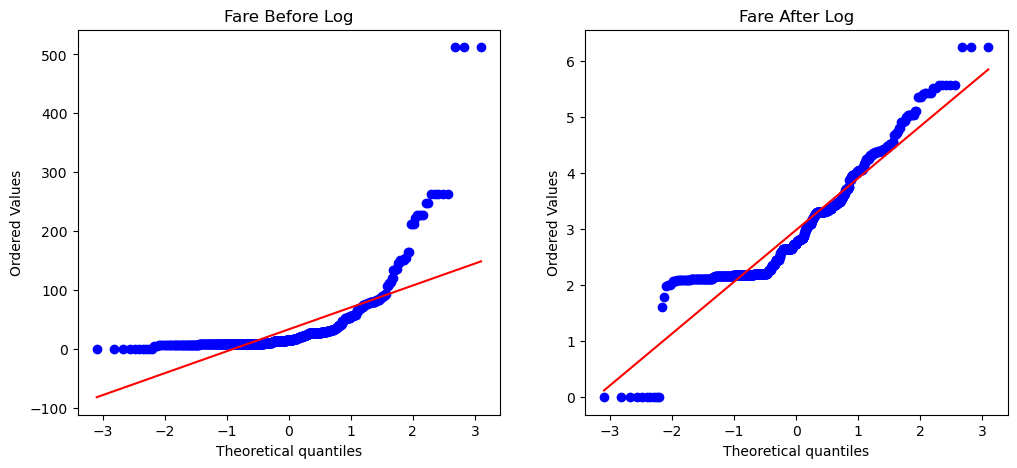

In [23]:
plt.figure(figsize =(12,5))

plt.subplot(121)
stats.probplot(x_train['Fare'],dist='norm',plot=plt)
plt.title('Fare Before Log')

plt.subplot(122)
stats.probplot(x_train_transformed['Fare'],dist ='norm',plot=plt)
plt.title('Fare After Log')

##### Column Transformer

In [26]:
trf2 = ColumnTransformer([('log',FunctionTransformer(np.log1p),['Fare'])],remainder='passthrough')


x_train_transformed2 = trf2.fit_transform(x_train)
x_test_transformed2 = trf2.transform(x_test)

clf.fit(x_train_transformed2,y_train)
clf2.fit(x_test_transformed2,y_test)

y_pred = clf.predict(x_test_transformed2)
y_pred2 = clf2.predict(x_test_transformed2)

print("LR Accuracy :", accuracy_score(y_test,y_pred))
print("DT Accuracy :", accuracy_score(y_test,y_pred2))

LR Accuracy : 0.7430167597765364
DT Accuracy : 0.9832402234636871


##### Other transformations

In [36]:
def apply_transform(transform):
    X = df.drop(columns=['Survived'])
    y = df['Survived']
    
    trf = ColumnTransformer([('log',FunctionTransformer(transform),['Fare'])],remainder='passthrough')
    
    X_trans = trf.fit_transform(X)
    
    clf = LogisticRegression()
    
    print("Accuracy",np.mean(cross_val_score(clf,X_trans,y,scoring='accuracy',cv=10)))
    
    plt.figure(figsize=(14,4))

    plt.subplot(121)
    stats.probplot(X['Fare'], dist="norm", plot=plt)
    plt.title('QQ plot of Fare Before Transform')

    plt.subplot(122)
    stats.probplot(X_trans[:,0], dist="norm", plot=plt)
    plt.title('QQ plot of Fare After Transform')

    plt.show()

Accuracy 0.6589013732833957


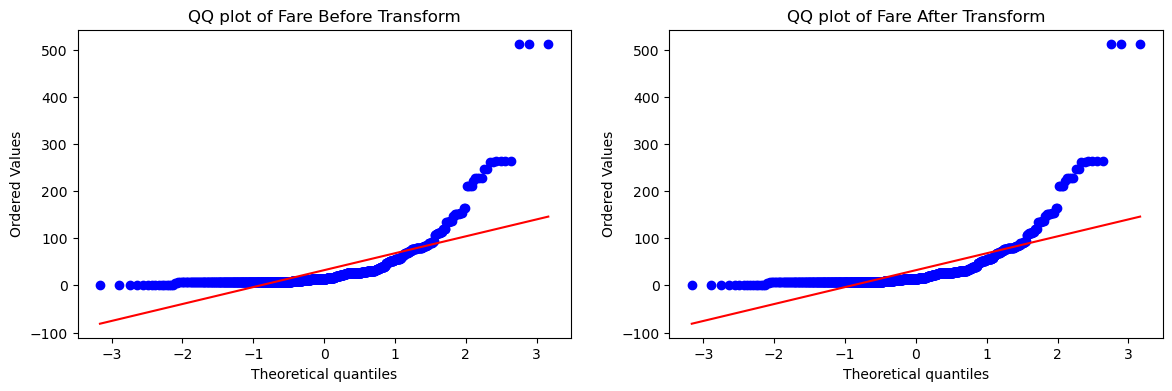

In [37]:
apply_transform(lambda x:x)

Accuracy 0.6442446941323345


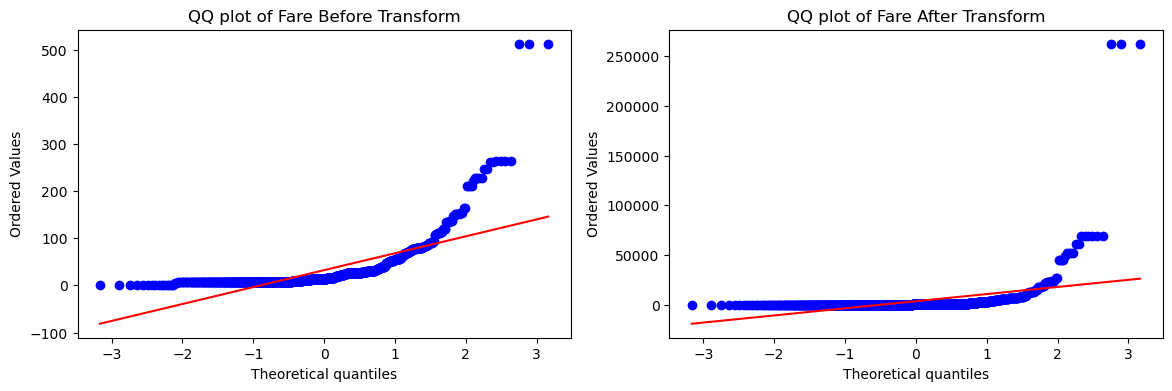

In [38]:
apply_transform(lambda x :x**2) # Squared transform is not performing better , it is mostly used on left skewed data

Accuracy 0.39843945068664166


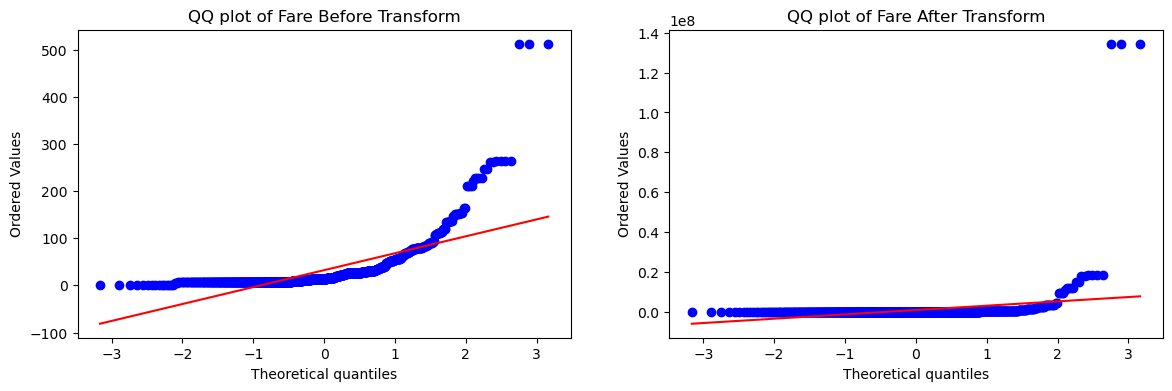

In [39]:
apply_transform(lambda x :x**3)

Accuracy 0.6589013732833957


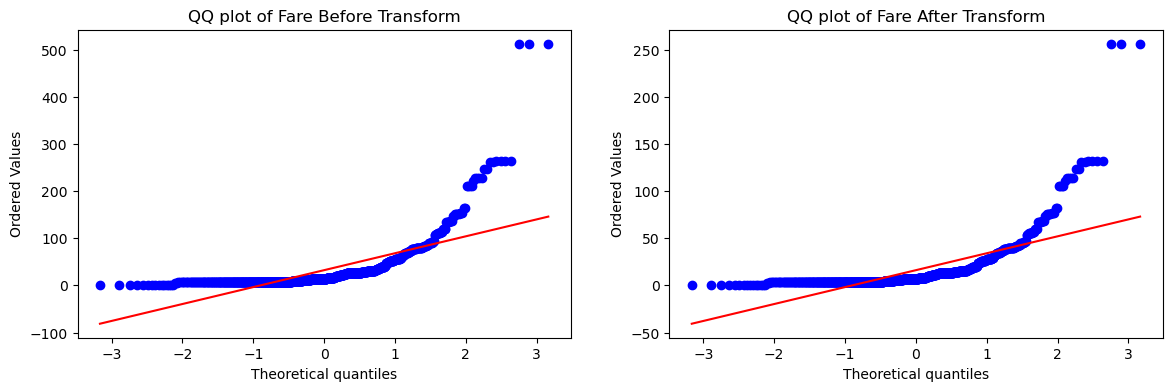

In [40]:
apply_transform(lambda x :x**1/2) # sqrt


Accuracy 0.61729088639201


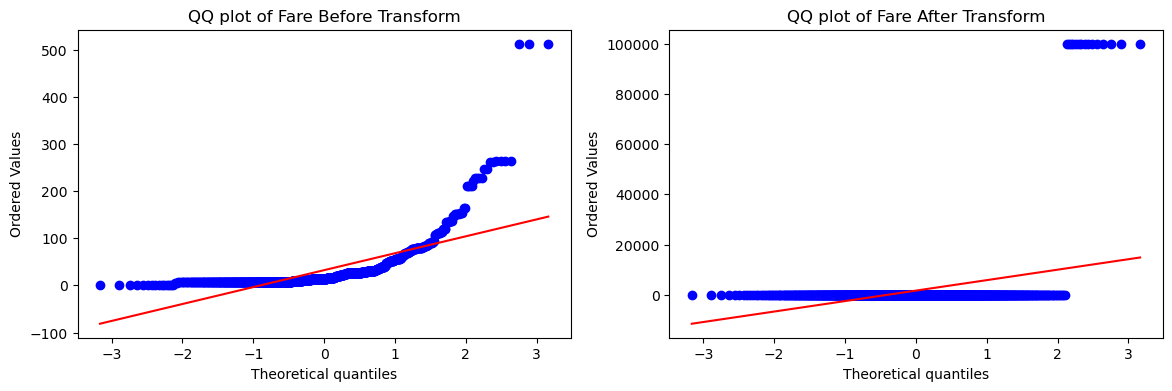

In [41]:
apply_transform(lambda x: 1/(x+0.00001)) #reciprocal

Accuracy 0.616167290886392


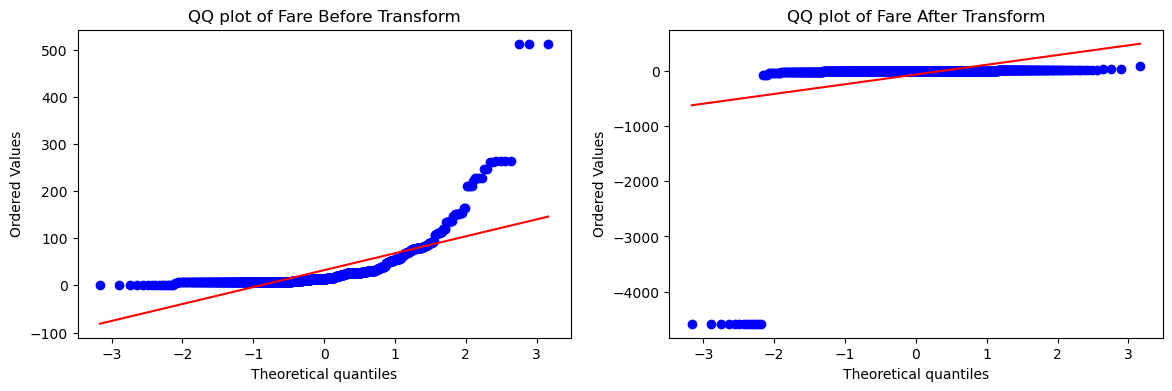

In [42]:
apply_transform(np.tan) #custom transform

Accuracy 0.6195131086142323


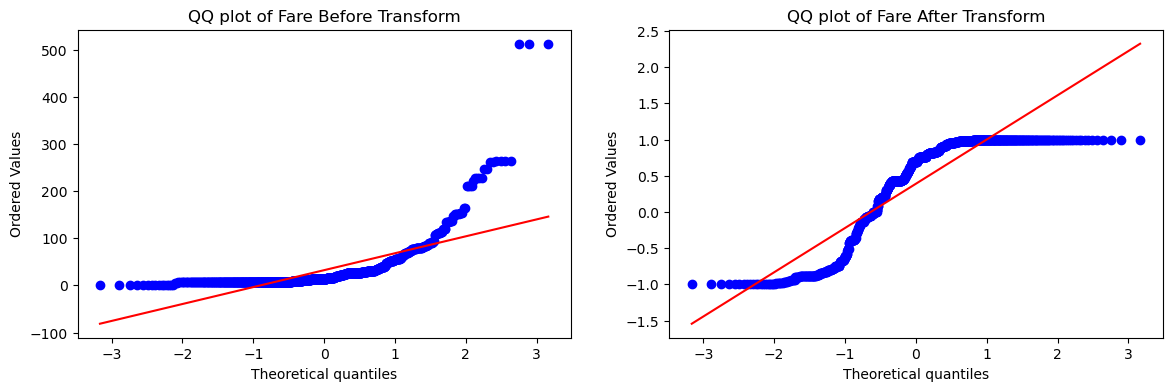

In [43]:
apply_transform(np.sin) #custom transform

Accuracy 0.6184144818976279


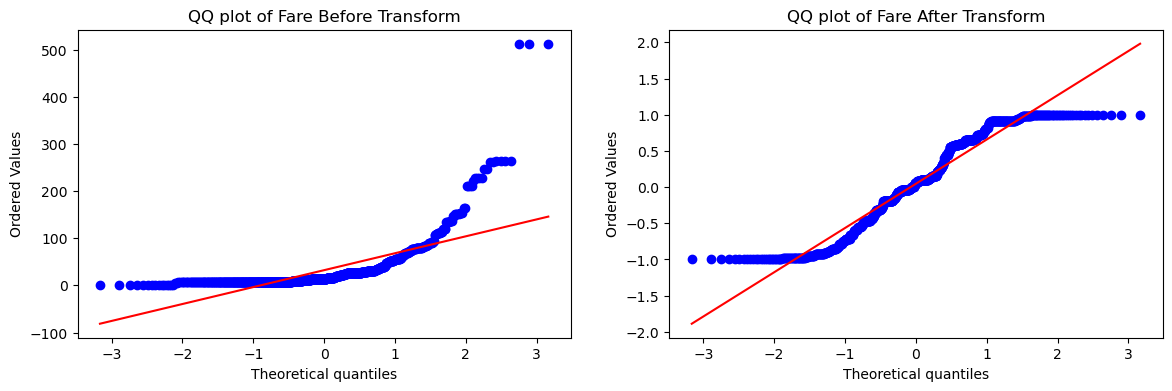

In [44]:
apply_transform(np.cos) #custom transform